<a href="https://colab.research.google.com/github/rohandatta/Face_Recognition_Drowsiness_Detection/blob/main/Capstone_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.
Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.


# Let's begin

In [ ]:
!pip install dlib
import dlib

In [ ]:
!pip install cmake

In [ ]:
!pip install face_recognition

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
from PIL import Image
from datetime import datetime
import io
import html
import time
import face_recognition

In [ ]:
def detect_face(image_path):
  face_cascade = cv2.CascadeClassifier('drive/MyDrive/Attendence system and drowsiness alert/haarcascade_frontalface_default.xml')
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    roigray = gray[y:y+h, x:x+w]
    roicolor = img[y:y+h, x:x+w]

  plt.grid(None)   
  plt.xticks([])
  plt.yticks([])
  imgplot = plt.imshow(img)

  return roicolor







In [ ]:
image_path = 'drive/MyDrive/Attendence system and drowsiness alert/Images'

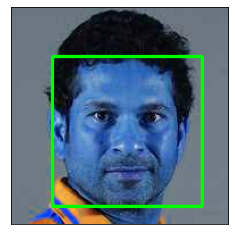

In [ ]:
face = detect_face(f'{image_path}/Sachin.jpg')

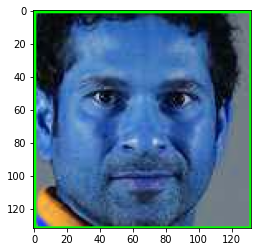

In [ ]:
plt.imshow(face)

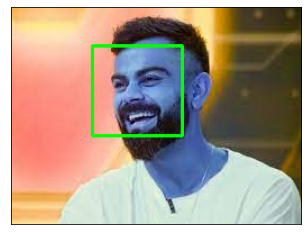

In [ ]:
face = detect_face(f'{image_path}/Virat.jpg')

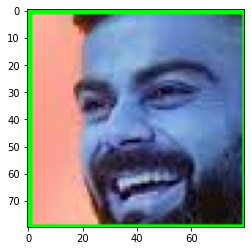

In [ ]:
plt.imshow(face)

# Now, lets build a face recognition system on static image

In [57]:

path = 'drive/MyDrive/Attendence system and drowsiness alert/Images'
images = []
names = []

mylist = os.listdir(path)
for img in mylist:
  curimg = cv2.imread(f'{path}/{img}')
  images.append(curimg)
  names.append(os.path.splitext(img)[0])

def get_encodings(images):
  encode_list = []
  for img in images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encode = face_recognition.face_encodings(img)[0]
    encode_list.append(encode)

  return encode_list

encodeList_known = get_encodings(images)


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def identify_face():

  from IPython.display import Image
  try:
    web_img = take_photo()
    print('Saved to {}'.format(web_img))
    
    # Show the image which was just taken.
    # display(Image(web_img))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))



  web_img = cv2.imread(web_img)
  scale_img = cv2.resize(web_img, (0,0), None, 0.25, 0.25)
  scale_img = cv2.cvtColor(scale_img, cv2.COLOR_BGR2RGB)

  facesCurFrame = face_recognition.face_locations(scale_img)
  encodesCurframe = face_recognition.face_encodings(scale_img, facesCurFrame)

  if len(facesCurFrame) == 0:
    print('No face Detected')

  for encodesCurface, faceloc in zip(encodesCurframe, facesCurFrame):
    matches = face_recognition.compare_faces(encodeList_known, encodesCurface)
    faceDis = face_recognition.face_distance(encodeList_known, encodesCurface)
    matchIndex = np.argmin(faceDis)

    if matches[matchIndex]:
      person_name = names[matchIndex].upper()
      print(person_name)

      (top, right, bottom, left) = faceloc
      top, right, bottom, left =  top * 4, right * 4, bottom * 4, left * 4
      cv2.rectangle(web_img, (left, top), (right, bottom), (0, 255, 0), 2)
      cv2.rectangle(web_img, (left, bottom + 35), (right, bottom), (0, 255, 0), cv2.FILLED)
      cv2.putText(web_img, person_name, (left + 6, bottom + 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255), 2)

      cv2_imshow(web_img)

    else:
      
      (top, right, bottom, left) = faceloc
      top, right, bottom, left =  top * 4, right * 4, bottom * 4, left * 4
      cv2.rectangle(web_img, (left, top), (right, bottom), (0, 255, 0), 2)
      cv2.rectangle(web_img, (left, bottom + 35), (right, bottom), (0, 255, 0), cv2.FILLED)
      cv2.putText(web_img, 'Unknown Face', (left + 6, bottom + 15), cv2.FONT_HERSHEY_PLAIN, 1.8, (255,255,255), 2)

      cv2_imshow(web_img)





<IPython.core.display.Javascript object>

Saved to photo.jpg
ROHAN


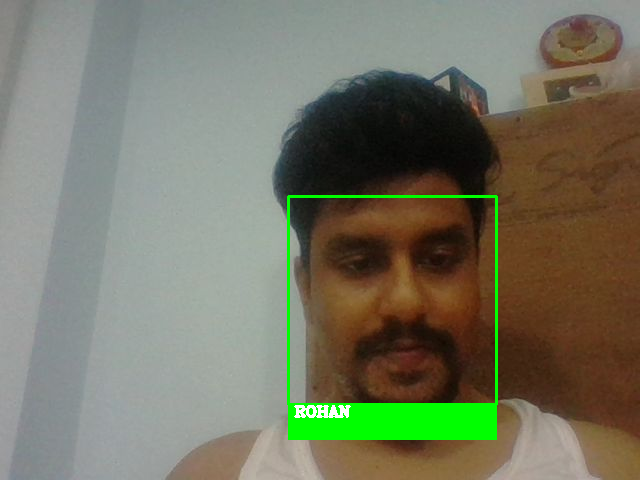

In [58]:
identify_face()

# Let's move to video stream to recognise face on real time

In [53]:
class face_identifier:

  def __init__(self, path):
    self.path = path
    self.images = []
    self.names = []

    mylist = os.listdir(path)
    for img in mylist:
      cur_img = cv2.imread(f'{path}/{img}')
      self.images.append(cur_img)
      self.names.append(os.path.splitext(img)[0])
    
    pass

  # function to convert the JavaScript object into an OpenCV image
  def js_to_image(self,js_reply):
    """
    Params:
            js_reply: JavaScript object containing image from webcam
    Returns:
            img: OpenCV BGR image
    """
    # decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

  # function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
  def bbox_to_bytes(self,bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

  # JavaScript to properly create our live video stream using our webcam as input
  def video_stream(self):
    js = Javascript('''
      var video;
      var div = null;
      var stream;
      var captureCanvas;
      var imgElement;
      var labelElement;
      
      var pendingResolve = null;
      var shutdown = false;
      
      function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
      }
      
      function onAnimationFrame() {
        if (!shutdown) {
          window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
          var result = "";
          if (!shutdown) {
            captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
            result = captureCanvas.toDataURL('image/jpeg', 0.8)
          }
          var lp = pendingResolve;
          pendingResolve = null;
          lp(result);
        }
      }
      
      async function createDom() {
        if (div !== null) {
          return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);
        
        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);
            
        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);
        
        const instruction = document.createElement('div');
        instruction.innerHTML = 
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };
        
        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640; //video.videoWidth;
        captureCanvas.height = 480; //video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);
        
        return stream;
      }
      async function stream_frame(label, imgData) {
        if (shutdown) {
          removeDom();
          shutdown = false;
          return '';
        }

        var preCreate = Date.now();
        stream = await createDom();
        
        var preShow = Date.now();
        if (label != "") {
          labelElement.innerHTML = label;
        }
              
        if (imgData != "") {
          var videoRect = video.getClientRects()[0];
          imgElement.style.top = videoRect.top + "px";
          imgElement.style.left = videoRect.left + "px";
          imgElement.style.width = videoRect.width + "px";
          imgElement.style.height = videoRect.height + "px";
          imgElement.src = imgData;
        }
        
        var preCapture = Date.now();
        var result = await new Promise(function(resolve, reject) {
          pendingResolve = resolve;
        });
        shutdown = false;
        
        return {'create': preShow - preCreate, 
                'show': preCapture - preShow, 
                'capture': Date.now() - preCapture,
                'img': result};
      }
      ''')

    display(js)
    
  def video_frame(self,label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

  def get_encodings(self):
    encode_list = []
    for img in self.images:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      encode = face_recognition.face_encodings(img)[0]
      encode_list.append(encode)

    return encode_list

  def start(self):
    # start streaming video from webcam
    self.video_stream()
    # label for video
    label_html = 'Capturing...'
    # initialze bounding box to empty
    bbox = ''
    count = 0 
    while True:
        js_reply = self.video_frame(label_html, bbox)
        if not js_reply:
            break

        # convert JS response to OpenCV Image
        web_img = self.js_to_image(js_reply["img"])

        # create transparent overlay for bounding box
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)

        # grayscale image for face detection
        # web_img = cv2.imread(img)
        scale_img = cv2.resize(web_img, (0,0), None, 0.25, 0.25)
        scale_img = cv2.cvtColor(scale_img, cv2.COLOR_BGR2RGB)

        facesCurFrame = face_recognition.face_locations(scale_img)
        encodesCurframe = face_recognition.face_encodings(scale_img, facesCurFrame)

        if len(facesCurFrame) == 0:
          print('No face Detected')

        for encodesCurface, faceloc in zip(encodesCurframe, facesCurFrame):
          matches = face_recognition.compare_faces(self.get_encodings(), encodesCurface, tolerance= 0.5)
          faceDis = face_recognition.face_distance(encodeList_known, encodesCurface)
          matchIndex = np.argmin(faceDis)

          if matches[matchIndex]:
            person_name = self.names[matchIndex].upper()
            # print(person_name)

            (top, right, bottom, left) = faceloc
            top, right, bottom, left =  top * 4, right * 4, bottom * 4, left * 4
            bbox_array = cv2.rectangle(bbox_array,(left,top),(right,bottom),(0, 255,0),2)
            cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.rectangle(bbox_array, (left, bottom + 35), (right, bottom), (0, 255, 0), cv2.FILLED)
            cv2.putText(bbox_array, person_name, (left + 6, bottom + 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255), 2)

            # cv2_imshow(web_img)

          else:
            
            (top, right, bottom, left) = faceloc
            top, right, bottom, left =  top * 4, right * 4, bottom * 4, left * 4
            cv2.rectangle(bbox_array, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.rectangle(bbox_array, (left, bottom + 35), (right, bottom), (0, 255, 0), cv2.FILLED)
            cv2.putText(bbox_array, 'Unknown Face', (left + 6, bottom + 15), cv2.FONT_HERSHEY_PLAIN, 1.8, (255,255,255), 2)

            # cv2_imshow(web_img)

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = self.bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes

  

  



  
  


In [54]:
recogniser = face_identifier('drive/MyDrive/Attendence system and drowsiness alert/Images')